<a href="https://colab.research.google.com/github/harish-git63/Demo1/blob/main/mini_p.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Review Prediction using LSTM — with Auto Column Debugging

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1. Load dataset
df = pd.read_csv("/content/Dataset-SA.csv")
print("Dataset loaded successfully!")
print("Columns in dataset:", df.columns.tolist())
print(df.head())

# 2. Identify text and target columns
text_column = "product_name"  # as per your dataset

# Auto-detect possible target columns (exclude text)
possible_targets = [col for col in df.columns if col != text_column]
print(f"Possible target columns: {possible_targets}")

# CHANGE THIS manually to your actual target column name if incorrect
target_column = possible_targets[-1]  # or manually e.g. 'sentiment', 'rating'
print(f"Using '{target_column}' as target column.")

# 3. Basic cleanup
df.dropna(subset=[text_column, target_column], inplace=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

texts = df[text_column].astype(str)
targets = df[target_column]

# 4. Encode target variable automatically
if targets.dtype == 'object':
    unique_vals = targets.unique()
    print(f"Target is categorical: {unique_vals}")
    targets = targets.astype('category').cat.codes
    output_activation = 'sigmoid' if len(unique_vals) == 2 else 'softmax'
    loss_type = 'binary_crossentropy' if len(unique_vals) == 2 else 'sparse_categorical_crossentropy'
    metrics_used = ['accuracy']
else:
    print("Target is numeric (regression).")
    output_activation = 'linear'
    loss_type = 'mse'
    metrics_used = ['mae']

y = targets.values

# 5. Text preprocessing (tokenization + padding)
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=200, truncating='post', padding='post')

# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(padded, y, test_size=0.2, random_state=42)

# 7. Build LSTM model
text_input = Input(shape=(200,))
embedding = Embedding(input_dim=10000, output_dim=64, input_length=200)(text_input)
lstm = LSTM(64, dropout=0.3, recurrent_dropout=0.3)(embedding)
dense1 = Dense(64, activation='relu')(lstm)
drop1 = Dropout(0.3)(dense1)
output = Dense(1 if output_activation != 'softmax' else len(np.unique(y)), activation=output_activation)(drop1)

model = Model(inputs=text_input, outputs=output)
model.compile(optimizer='adam', loss=loss_type, metrics=metrics_used)
model.summary()

# 8. Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=64,
    verbose=1
)

# 9. Evaluate model
eval_result = model.evaluate(X_test, y_test)
print(f"\nEvaluation Results: {dict(zip(model.metrics_names, eval_result))}")

# 10. Plot accuracy/MAE and loss
plt.figure(figsize=(12,5))

if 'accuracy' in history.history:
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
else:
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title('Model MAE Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Dataset loaded successfully!
Columns in dataset: ['product_name', 'product_price', 'Rate', 'Review', 'Summary', 'Sentiment']
                                        product_name product_price Rate  \
0  Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    5   
1  Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    5   
2  Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    3   
3  Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    1   
4  Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    3   

            Review                                            Summary  \
0           super!  great cooler excellent air flow and for this p...   
1          awesome              best budget 2 fit cooler nice cooling   
2             fair  the quality is good but the power of air is de...   
3  useless product                  very bad product its a only a fan   
4             fair                                      ok 

KeyboardInterrupt: 

In [3]:
# Review Prediction using LSTM — with Preprocessing

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# ------------------ 1. Load dataset ------------------
df = pd.read_csv("/content/Dataset-SA.csv")
print("Dataset loaded successfully!")
print("Columns in dataset:", df.columns.tolist())
print(df.head())

# ------------------ 2. Identify text and target columns ------------------
text_column = "product_name"  # Change if your text column is different

# Auto-detect possible target columns (exclude text)
possible_targets = [col for col in df.columns if col != text_column]
print(f"Possible target columns: {possible_targets}")

# Use last column as target by default (or manually set)
target_column = possible_targets[-1]
print(f"Using '{target_column}' as target column.")

# ------------------ 3. Basic cleanup ------------------
df.dropna(subset=[text_column, target_column], inplace=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# ------------------ 3a. Text preprocessing ------------------
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

texts = df[text_column].astype(str).apply(preprocess_text)
targets = df[target_column]

# ------------------ 4. Encode target variable ------------------
if targets.dtype == 'object':
    unique_vals = targets.unique()
    print(f"Target is categorical: {unique_vals}")
    targets = targets.astype('category').cat.codes
    output_activation = 'sigmoid' if len(unique_vals) == 2 else 'softmax'
    loss_type = 'binary_crossentropy' if len(unique_vals) == 2 else 'sparse_categorical_crossentropy'
    metrics_used = ['accuracy']
else:
    print("Target is numeric (regression).")
    output_activation = 'linear'
    loss_type = 'mse'
    metrics_used = ['mae']

y = targets.values

# ------------------ 5. Text tokenization + padding ------------------
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=200, truncating='post', padding='post')

# ------------------ 6. Train-Test Split ------------------
X_train, X_test, y_train, y_test = train_test_split(padded, y, test_size=0.2, random_state=42)

# ------------------ 7. Build LSTM model ------------------
text_input = Input(shape=(200,))
embedding = Embedding(input_dim=10000, output_dim=64, input_length=200)(text_input)
lstm = LSTM(64, dropout=0.3, recurrent_dropout=0.3)(embedding)
dense1 = Dense(64, activation='relu')(lstm)
drop1 = Dropout(0.3)(dense1)
output = Dense(1 if output_activation != 'softmax' else len(np.unique(y)), activation=output_activation)(drop1)

model = Model(inputs=text_input, outputs=output)
model.compile(optimizer='adam', loss=loss_type, metrics=metrics_used)
model.summary()

# ------------------ 8. Train model ------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=64,
    verbose=1
)

# ------------------ 9. Evaluate model ------------------
eval_result = model.evaluate(X_test, y_test)
print(f"\nEvaluation Results: {dict(zip(model.metrics_names, eval_result))}")

# ------------------ 10. Plot accuracy/MAE and loss ------------------
plt.figure(figsize=(12,5))

if 'accuracy' in history.history:
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
else:
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title('Model MAE Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Dataset loaded successfully!
Columns in dataset: ['product_name', 'product_price', 'Rate', 'Review', 'Summary', 'Sentiment']
                                        product_name product_price Rate  \
0  Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    5   
1  Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    5   
2  Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    3   
3  Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    1   
4  Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    3   

            Review                                            Summary  \
0           super!  great cooler excellent air flow and for this p...   
1          awesome              best budget 2 fit cooler nice cooling   
2             fair  the quality is good but the power of air is de...   
3  useless product                  very bad product its a only a fan   
4             fair                                      ok 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 200, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 677,379 (2.58 MB)

 Trainable params: 677,379 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
  71/2564 ━━━━━━━━━━━━━━━━━━━━ 6:51 165ms/step - accuracy: 0.7468 - loss: 0.7910

KeyboardInterrupt: 

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dataset loaded successfully!
Columns in dataset: ['product_name', 'product_price', 'Rate', 'Review', 'Summary', 'Sentiment']
                                        product_name product_price Rate  \
0  Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    5   
1  Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    5   
2  Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    3   
3  Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    1   
4  Candes 12 L Room/Personal Air Cooler??????(Whi...          3999    3   

            Review                                            Summary  \
0           super!  great cooler excellent air flow and for this p...   
1          awesome              best budget 2 fit cooler nice cooling   
2             fair  the quality is good but the power of air is de...   
3  useless product                  very bad product its a only a fan   
4             fair                                      ok 

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 200, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 677,379 (2.58 MB)

 Trainable params: 677,379 (2.58 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
2564/2564 ━━━━━━━━━━━━━━━━━━━━ 462s 179ms/step - accuracy: 0.8083 - loss: 0.6154 - val_accuracy: 0.8151 - val_loss: 0.5885
Epoch 2/5
2564/2564 ━━━━━━━━━━━━━━━━━━━━ 488s 174ms/step - accuracy: 0.8097 - loss: 0.6013 - val_accuracy: 0.8151 - val_loss: 0.5874
Epoch 3/5
2564/2564 ━━━━━━━━━━━━━━━━━━━━ 449s 175ms/step - accuracy: 0.8126 - loss: 0.5938 - val_accuracy: 0.8151 - val_loss: 0.5870
Epoch 4/5
2564/2564 ━━━━━━━━━━━━━━━━━━━━ 536s 189ms/step - accuracy: 0.8112 - loss: 0.5957 - val_accuracy: 0.8151 - val_loss: 0.5864
Epoch 5/5
2564/2564 ━━━━━━━━━━━━━━━━━━━━ 457s 178ms/step - accuracy: 0.8121 - loss: 0.5925 - val_accuracy: 0.8151 - val_loss: 0.5866
1282/1282 ━━━━━━━━━━━━━━━━━━━━ 32s 25ms/step - accuracy: 0.8172 - loss: 0.5821

Evaluation Results: {'loss': 0.5866106748580933, 'compile_metrics': 0.8151227831840515}


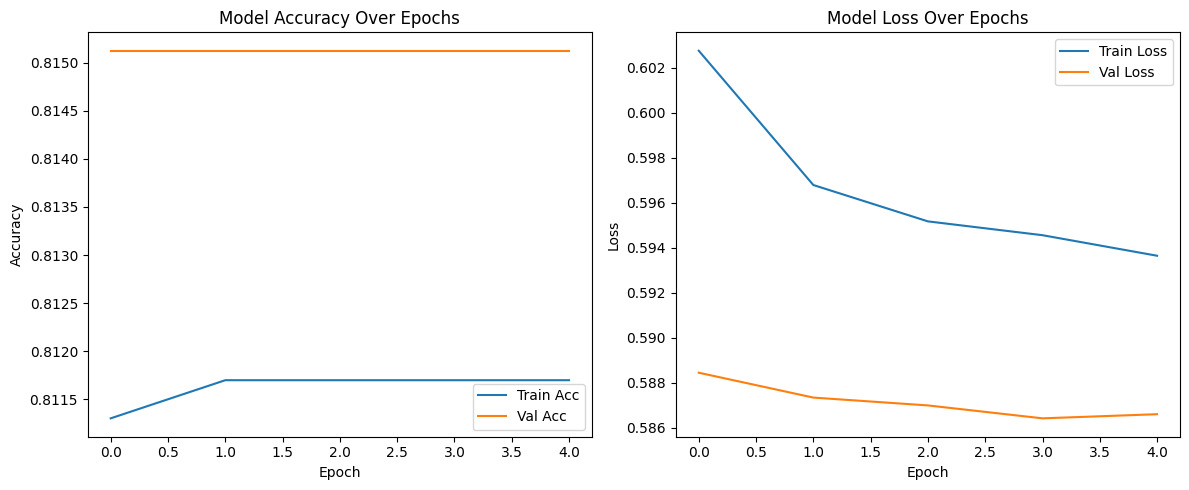

In [4]:
# Review Prediction using LSTM — with Preprocessing

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.corpus import stopwords

# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# ------------------ 1. Load dataset ------------------
df = pd.read_csv("/content/Dataset-SA.csv")
print("Dataset loaded successfully!")
print("Columns in dataset:", df.columns.tolist())
print(df.head())

# ------------------ 2. Identify text and target columns ------------------
text_column = "product_name"  # Change if your text column is different

# Auto-detect possible target columns (exclude text)
possible_targets = [col for col in df.columns if col != text_column]
print(f"Possible target columns: {possible_targets}")

# Use last column as target by default (or manually set)
target_column = possible_targets[-1]
print(f"Using '{target_column}' as target column.")

# ------------------ 3. Basic cleanup ------------------
df.dropna(subset=[text_column, target_column], inplace=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# ------------------ 3a. Text preprocessing ------------------
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

texts = df[text_column].astype(str).apply(preprocess_text)
targets = df[target_column]

# ------------------ 4. Encode target variable ------------------
if targets.dtype == 'object':
    unique_vals = targets.unique()
    print(f"Target is categorical: {unique_vals}")
    targets = targets.astype('category').cat.codes
    output_activation = 'sigmoid' if len(unique_vals) == 2 else 'softmax'
    loss_type = 'binary_crossentropy' if len(unique_vals) == 2 else 'sparse_categorical_crossentropy'
    metrics_used = ['accuracy']
else:
    print("Target is numeric (regression).")
    output_activation = 'linear'
    loss_type = 'mse'
    metrics_used = ['mae']

y = targets.values

# ------------------ 5. Text tokenization + padding ------------------
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=200, truncating='post', padding='post')

# ------------------ 6. Train-Test Split ------------------
X_train, X_test, y_train, y_test = train_test_split(padded, y, test_size=0.2, random_state=42)

# ------------------ 7. Build LSTM model ------------------
text_input = Input(shape=(200,))
embedding = Embedding(input_dim=10000, output_dim=64, input_length=200)(text_input)
lstm = LSTM(64, dropout=0.3, recurrent_dropout=0.3)(embedding)
dense1 = Dense(64, activation='relu')(lstm)
drop1 = Dropout(0.3)(dense1)
output = Dense(1 if output_activation != 'softmax' else len(np.unique(y)), activation=output_activation)(drop1)

model = Model(inputs=text_input, outputs=output)
model.compile(optimizer='adam', loss=loss_type, metrics=metrics_used)
model.summary()

# ------------------ 8. Train model ------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=5,
    batch_size=64,
    verbose=1
)

# ------------------ 9. Evaluate model ------------------
eval_result = model.evaluate(X_test, y_test)
print(f"\nEvaluation Results: {dict(zip(model.metrics_names, eval_result))}")

# ------------------ 10. Plot accuracy/MAE and loss ------------------
plt.figure(figsize=(12,5))

if 'accuracy' in history.history:
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Model Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
else:
    plt.subplot(1, 2, 1)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Val MAE')
    plt.title('Model MAE Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
